In [111]:
import os
from collections import Counter

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import probscale
import itertools

from pathlib import Path

class Result:
    def __init__(self, warm_up_stream_length=1000, name="sigmod.06.28", parallelism=3, rate=5, watermarks=False, iterations=10, distributed_acker=False, skip=0, stream_length=2000):
        self.warm_up_stream_length = warm_up_stream_length
        self.name = name
        self.parallelism = parallelism
        self.distributed_acker = distributed_acker
        self.rate = rate
        self.watermarks = watermarks
        self.iterations = iterations
        self.skip = skip
        self.stream_length = stream_length

    def path(self):
        return Path(f"results/warm_up_stream_length={self.warm_up_stream_length}/{self.name}/stream_length={self.stream_length}/parallelism={self.parallelism}/distributed_acker={self.distributed_acker}/rate={self.rate}/watermarks={self.watermarks}/iterations={self.iterations}/flamestream")
    
    def lat_data(self):
        with open(self.path().joinpath("latency/lat.data"), 'r') as file:
            return list(map(int, file.read().split(", ")))[self.skip:]
        
    def duration(self):
        with open(self.path().joinpath("duration.txt"), 'r') as file:
            return int(file.read())
        
    def durations(self):
        with open(self.path().joinpath("durations.txt"), 'r') as file:
            return list(map(int, file.read().split(", ")))[self.skip:]
    
    def throughput_hz(self, skip=0):
        durations = self.durations()
        return (len(durations) - skip) / (durations[-1] - durations[skip]) * 1E9

    def plot_latencies_evolution(self, window_size=100, q=0.95, stabilize=True):
        def each_slice(generator, n):
            group = []
            for element in generator:
                group.append(element)
                if len(group) == n:
                    yield group
                    group = []

            if group:
                yield group

        quantiles = []
        prev_quantile = None
        is_stable = not stabilize
        for window in each_slice(self.lat_data(), window_size):
            quantile = np.quantile(window, q)
            if is_stable:
                quantiles.append(quantile)
            elif prev_quantile and prev_quantile < quantile:
                is_stable = True
                quantiles.append(prev_quantile)
                quantiles.append(quantile)
            else:
                prev_quantile = quantile
            prev_window = window
        if not is_stable:
            raise "has not stabilized"
        plt.plot(quantiles)
        
def results_path(parallelism=3, rate=5, watermarks=False):
    return Path(f"results/sigmod/parallelism={parallelism}/distributed_acker={False}/rate={rate}/watermarks={watermarks}/iterations=10/flamestream")

def plot_probabilities(results_by_legends, legend_title=None, plot_title=None):
    fig, ax = plt.subplots(figsize=(10,10))
    ax.legend(results_by_legends.keys(), title=legend_title)
    for result in results_by_legends.values():
        plt.plot(*probscale.plot_pos(result.lat_data()))
    plt.xlabel('Percentile')
    plt.ylabel('Latency, ns')
    plt.title(plot_title)
    plt.show()
    
def plot_percentile(percentile, results_by_rates):
    fig, ax = plt.subplots(figsize=(10,10))
    plt.plot(
        results_by_rates.keys(),
        [np.percentile(result.lat_data(), percentile) for result in results_by_rates.values()]
    )
    plt.xlabel('Rate')
    plt.ylabel('Latency, ns')
    plt.show()
    
def plot_percentile_by_throughput(percentile, results):
    plt.plot(*plottable_percentile_by_throughput(percentile, results))
    
def plottable_percentile_by_throughput(percentile, results):
    return (
        [result.throughput() for result in results],
        [np.percentile(result.lat_data(), percentile) for result in results]
    )

def plot_throughput_by_number_of_iterations(results):
    plt.plot(
        [result.iterations for result in results],
        [result.throughput() for result in results],
    )
    
def show_max_throughput(result_factory, bad_rate, max_rate):
    pass

def plot_throughput_by_parallelism(results):
    plt.plot(
        [result.parallelism for result in results],
        [result.throughput_hz() for result in results],
    )
    
def plot_latencies_barh(results_by_labels, ax):
    w = .70
    ind_fs = [1, 2.0, 3.0]

    def do_plot(q, c):
        ax.barh(range(len(results_by_labels)), [np.percentile(result.lat_data(), q) for result in results_by_labels.values()], color=c, height=w, left=0)

    do_plot(99, '.8')
    do_plot(90, '.6')
    do_plot(75, '.4')
    do_plot(50, '.2')

    plt.gca().invert_yaxis()

    for tick in ax.xaxis.get_major_ticks(): tick.label.set_fontsize(60)

    ax.set_yticklabels([])
#     plt.xlim((0, np.percentile(latencies[8], 99) + 100))

    ax.set_xlabel('Latency(ms)', fontsize=60)

    for i, label in enumerate(results_by_labels):
        ax.text(np.percentile(results_by_labels[label].lat_data(), 99) + 10, i, label, fontsize = 60)

    patch_99 = mpatches.Patch(color='.8', label='99 %-ile')
    patch_90 = mpatches.Patch(color='.6', label='95 %-ile')
    patch_75 = mpatches.Patch(color='.4', label='75 %-ile')
    patch_50 = mpatches.Patch(color='.2', label='50 %-ile')
    ax.legend(handles=[patch_99, patch_90, patch_75, patch_50][::-1], fontsize = 60, frameon=False, bbox_to_anchor=(1, 1), ncol=1)

    for spine in plt.gca().spines.values():
        spine.set_visible(False)

# Acker против Low watermarks

## Находим переломный rate

### Watermarks

Text(0, 0.5, 'Median latency, ns')

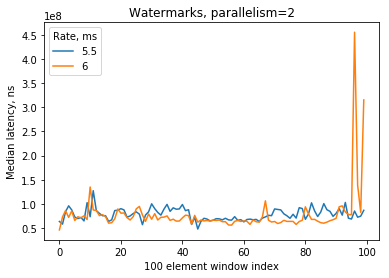

In [15]:
Result(
    rate=5.5, parallelism=2, iterations=50, watermarks=True, stream_length=10000
).plot_latencies_evolution(q=0.5, stabilize=False)
Result(
    rate=6, parallelism=2, iterations=50, watermarks=True, stream_length=10000
).plot_latencies_evolution(q=0.5, stabilize=False)
plt.title("Watermarks, parallelism=2")
plt.legend([5.5, 6], title="Rate, ms")
plt.xlabel("100 element window index")
plt.ylabel("Median latency, ns")

Text(0, 0.5, 'Median latency, ns')

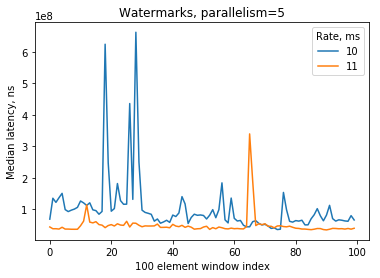

In [16]:
Result(
    rate=10, parallelism=5, iterations=50, watermarks=True, stream_length=10000
).plot_latencies_evolution(q=0.5, stabilize=False)
Result(
    rate=11, parallelism=5, iterations=50, watermarks=True, stream_length=10000
).plot_latencies_evolution(q=0.5, stabilize=False)
plt.title("Watermarks, parallelism=5")
plt.legend([10, 11], title="Rate, ms")
plt.xlabel("100 element window index")
plt.ylabel("Median latency, ns")

Text(0, 0.5, 'Median latency, ns')

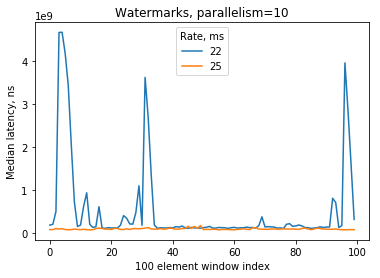

In [17]:
Result(
    rate=22, parallelism=10, iterations=50, watermarks=True, stream_length=10000
).plot_latencies_evolution(q=0.5, stabilize=False)
Result(
    rate=25, parallelism=10, iterations=50, watermarks=True, stream_length=10000
).plot_latencies_evolution(q=0.5, stabilize=False)
plt.title("Watermarks, parallelism=10")
plt.legend([22, 25], title="Rate, ms")
plt.xlabel("100 element window index")
plt.ylabel("Median latency, ns")

### Acker

Text(0, 0.5, 'Median latency, ns')

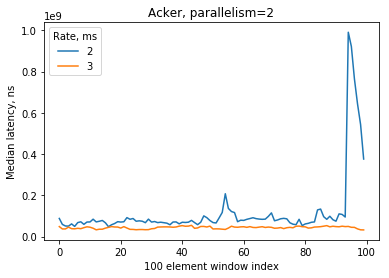

In [13]:
Result(
    rate=2, parallelism=2, iterations=50, watermarks=False, stream_length=10000
).plot_latencies_evolution(q=0.5, stabilize=False)
Result(
    rate=3, parallelism=2, iterations=50, watermarks=False, stream_length=10000
).plot_latencies_evolution(q=0.5, stabilize=False)
plt.title("Acker, parallelism=2")
plt.legend([2, 3], title="Rate, ms")
plt.xlabel("100 element window index")
plt.ylabel("Median latency, ns")

Text(0, 0.5, 'Median latency, ns')

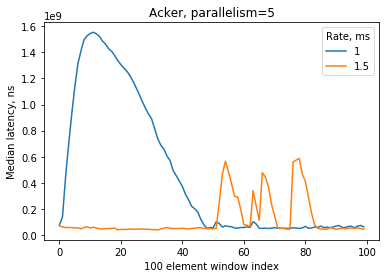

In [12]:
Result(
    rate=1, parallelism=5, iterations=50, watermarks=False, stream_length=10000
).plot_latencies_evolution(q=0.5, stabilize=False)
Result(
    rate=1.5, parallelism=5, iterations=50, watermarks=False, stream_length=10000
).plot_latencies_evolution(q=0.5, stabilize=False)
plt.title("Acker, parallelism=5")
plt.legend([1, 1.5], title="Rate, ms")
plt.xlabel("100 element window index")
plt.ylabel("Median latency, ns")

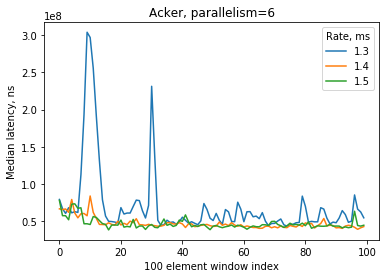

In [21]:
plt.title("Acker, parallelism=6")
plt.xlabel("100 element window index")
plt.ylabel("Median latency, ns")
rates = [1.3, 1.4, 1.5]
for rate in rates:
    Result(
        rate=rate, parallelism=6, iterations=50, watermarks=False, stream_length=10000
    ).plot_latencies_evolution(q=0.5, stabilize=False)
plt.legend(rates, title="Rate, ms")

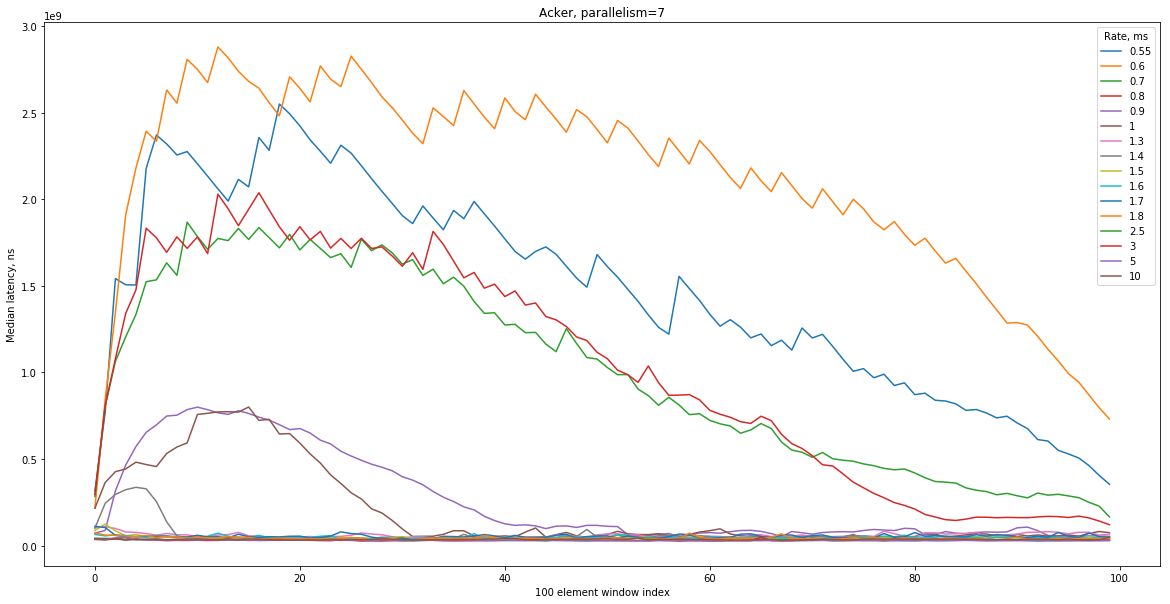

In [86]:
plt.subplots(figsize=(20, 10))
plt.title("Acker, parallelism=7")
plt.xlabel("100 element window index")
plt.ylabel("Median latency, ns")
plt.legend([
    Result(
        rate=rate, parallelism=7, iterations=50, watermarks=False, stream_length=10000, skip=0000
    ).plot_latencies_evolution(q=0.5, stabilize=False) and False or rate
    for rate in [0.55, 0.6, 0.7, 0.8, 0.9, 1, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 2.5, 3, 5, 10]
], title="Rate, ms")

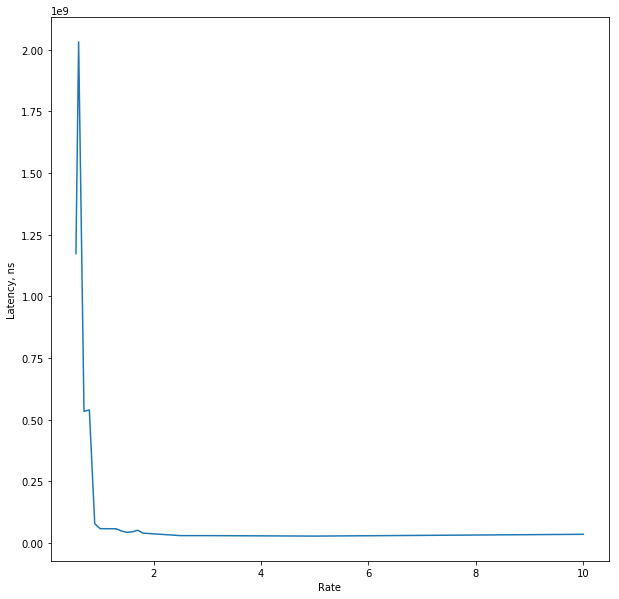

In [80]:
plot_percentile(50, {
    rate: Result(rate=rate, parallelism=7, iterations=50, watermarks=False, stream_length=10000, skip=8000)
    for rate in [0.55, 0.6, 0.7, 0.8, 0.9, 1, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 2.5, 3, 5, 10]
})

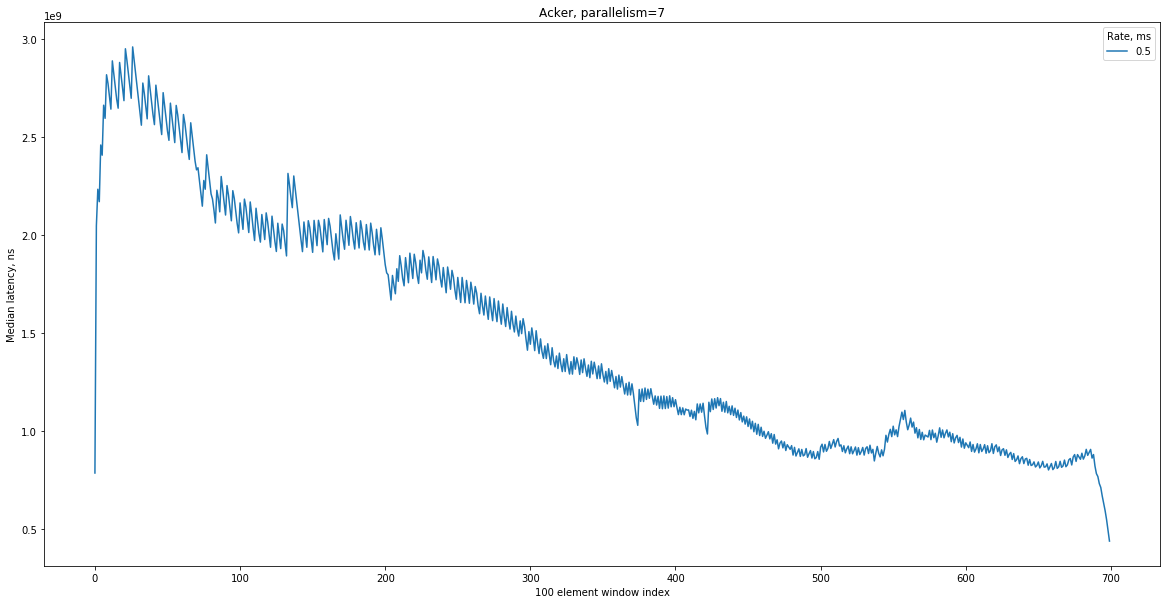

In [117]:
plt.subplots(figsize=(20, 10))
plt.title("Acker, parallelism=7")
plt.xlabel("100 element window index")
plt.ylabel("Median latency, ns")
plt.legend([
    Result(
        rate=rate, parallelism=7, iterations=50, watermarks=False, stream_length=70000
    ).plot_latencies_evolution(q=0.5, stabilize=False) and False or rate
    for rate in [0.5]
], title="Rate, ms")

Text(0, 0.5, 'Median latency, ns')

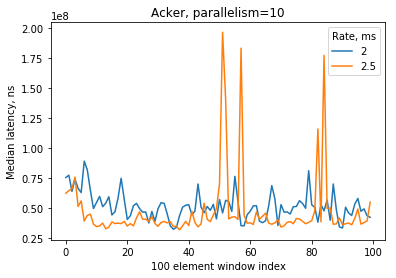

In [114]:
Result(
    rate=1.5, parallelism=10, iterations=50, watermarks=False, stream_length=10000
).plot_latencies_evolution(q=0.5, stabilize=False)
Result(
    rate=2.5, parallelism=10, iterations=50, watermarks=False, stream_length=10000
).plot_latencies_evolution(q=0.5, stabilize=False)
plt.title("Acker, parallelism=10")
plt.legend([2, 2.5], title="Rate, ms")
plt.xlabel("100 element window index")
plt.ylabel("Median latency, ns")

Text(0, 0.5, 'Throughput, Hz')

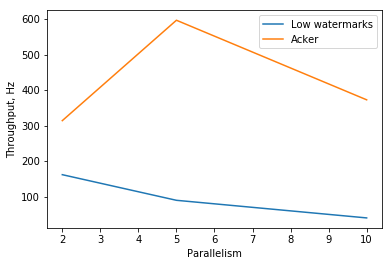

In [64]:
plot_throughput_by_parallelism([
    Result(
        name="sigmod.06.12", rate=6, parallelism=2, iterations=50, watermarks=True, stream_length=10000
    ),
    Result(
        name="sigmod.06.12", rate=11, parallelism=5, iterations=50, watermarks=True, stream_length=10000
    ),
    Result(
        name="sigmod.06.12", rate=25, parallelism=10, iterations=50, watermarks=True, stream_length=10000
    ),
])
plot_throughput_by_parallelism([
    Result(
        name="sigmod.06.12", rate=3, parallelism=2, iterations=50, watermarks=False, stream_length=10000
    ),
    Result(
        name="sigmod.06.12", rate=1.5, parallelism=5, iterations=50, watermarks=False, stream_length=10000
    ),
    Result(
        name="sigmod.06.12", rate=2.5, parallelism=10, iterations=50, watermarks=False, stream_length=10000
    ),
])
plt.legend(["Low watermarks", "Acker"])
plt.xlabel("Parallelism")
plt.ylabel("Throughput, Hz")

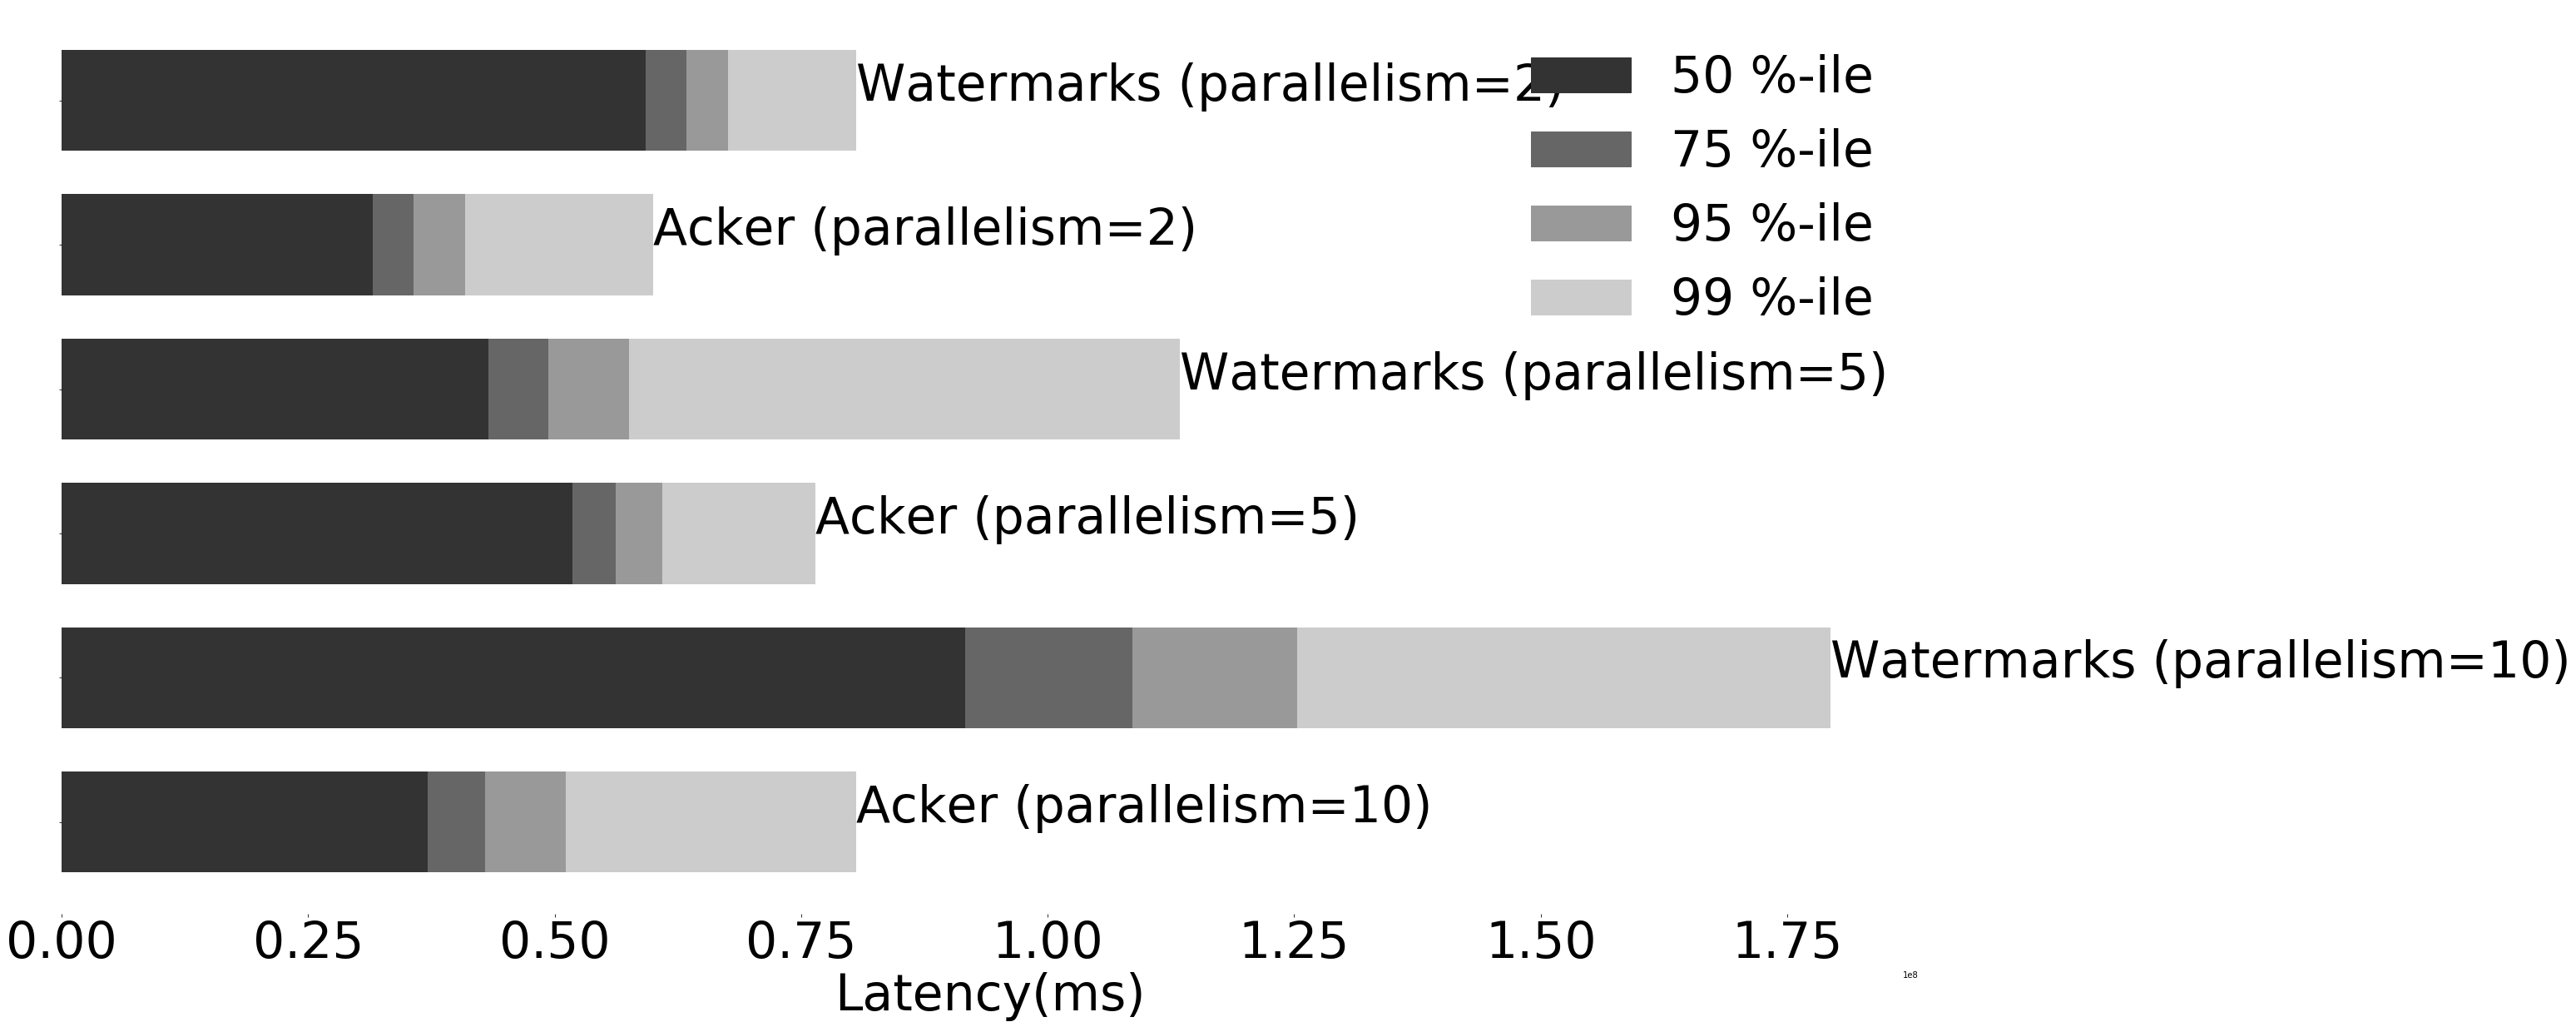

In [66]:
plot_latencies_barh({
    "Watermarks (parallelism=2)": Result(
        name="sigmod.06.12", rate=6, parallelism=2, iterations=50, watermarks=True, stream_length=10000
    ),
    "Acker (parallelism=2)": Result(
        name="sigmod.06.12", rate=3, parallelism=2, iterations=50, watermarks=False, stream_length=10000
    ),
    "Watermarks (parallelism=5)": Result(
        name="sigmod.06.12", rate=11, parallelism=5, iterations=50, watermarks=True, stream_length=10000
    ),
    "Acker (parallelism=5)": Result(
        name="sigmod.06.12", rate=1.5, parallelism=5, iterations=50, watermarks=False, stream_length=10000
    ),
    "Watermarks (parallelism=10)": Result(
        name="sigmod.06.12", rate=25, parallelism=10, iterations=50, watermarks=True, stream_length=10000
    ),
    "Acker (parallelism=10)": Result(
        name="sigmod.06.12", rate=2.5, parallelism=10, iterations=50, watermarks=False, stream_length=10000
    ),
}, plt.subplots(figsize=(40, 20))[1])